<a href="https://colab.research.google.com/github/mqc25/Cell_count/blob/master/Patch_Grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
Find Good Patches

'''


### Imports
%matplotlib inline 
#inline

import os
import sys
import random
import math
import string
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import matplotlib.patches as patches
import imageio

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle


In [0]:
'''
Data directories
'''

use_google_colab = 1 #toggle COLAB setup 
image_type = 0 #0=BCD
if (use_google_colab == 1):
    ############################################################################
    # Read Data from google drive
    ############################################################################
    from google.colab import drive #for loading gdrive data
    drive.mount('/content/gdrive')

    ###                     MAIN DIRECTORY NAMES
    gdir = '/content/gdrive/My Drive/'
    main_directory = gdir


    if (image_type == 0):
        #main directory for test_prediction_data set
        tp_dir = os.path.join(gdir,'BE224B_2020','Central BCD4')
        mini_pickle = os.path.join(gdir,'BE224B_2020','Zmini_images.pck')
        extracted_pickle = os.path.join(gdir,'BE224B_2020','Zextracted_images.pck')
        row_locations = os.path.join(gdir,'BE224B_2020','Zrow_col.csv')

    else:
        print('Incorrect Image Type selected')
        sys.exit()

else:
    ############################################################################
    # Read Data from local drive
    ############################################################################
    print('INSERT LOCAL DRIVE INFO')
    sys.exit()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def get_square(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nsize = np.shape(data_in)
    nrow = nsize[0]
    ncol = nsize[1]

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow -1
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol -1

    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]


    submatrix = data_in[lowrow:highrow,lowcol:highcol]
    return submatrix

In [0]:
'''
Get data folders
'''
if (image_type == 0):
    severity_list = os.listdir(tp_dir)

    patient_folder={}
    for sname in severity_list:
        full_path = os.path.join(tp_dir,sname)
        subfolder = os.listdir(full_path)
        print(subfolder)
        patient_folder[sname]=[]
        for ii in subfolder:
            patient_folder[sname].append(ii)
elif(image_type == 1):
    subfolder_list = os.listdir(image_dir)    
else:
    print('default case')
    subfolder_list = os.listdir(image_dir)


['74-os-1', 'Anonymized', '65-od-1', '50-os-54', '12-od-0', '65-od-2', '74-os-2', '50-os-53', '12-od-1', '12-od-2']
['39-od-13', '14-od-6', '87-od-3', 'Anonymized', '87-os-38', '87-os-37', '87-od-2', '14-od-5', '39-od-12']
['4-od-18', '76-od-7', 'Anonymized', '76-od-8', '4-os-1', '50-od-9']
['N1-od-2', 'N2-od-0', 'N3-od-2', 'Anonymized', 'N1-os-46', 'N3-od-1', 'N1-od-1', 'N2-od-6', 'N1-os-47']


In [0]:
'''
Load the data by severity folders or aggregate folders
'''

if (image_type == 0):

    #BCD2 image set,just use the anon folder data
    im={}
    mini_im={} #subset images from counter image file
    extracted_2nd_image ={} #larger subset image from counter file
    rr ={}
    cc ={}

    full_patient_list ={}
    for sname in severity_list:
        folders = patient_folder[sname]
        full_patient_list[sname] ={}

        #
        # We are concerned with ANON folders for the annotation
        #
        for folder_name in folders:
            if 'ANON' in folder_name.upper():
                full_patient_list[sname][folder_name] = os.path.join(tp_dir,sname,folder_name)
            else:
                full_patient_list[sname][folder_name] = os.path.join(tp_dir,sname,folder_name)

    #
    # Get file listing
    #
    patient_files ={} #hold the anon images
    case_files = {} #hold files for each case folder
    for sname in full_patient_list.keys(): #severity folders
        patient_files[sname]= []
        case_files[sname] ={}

        #if 'ANON' in sname.upper():
            #get files only from anonymous folders
        for sub_dir in full_patient_list[sname]:
            if 'ANON' in sub_dir.upper():

                case_files[sname][sub_dir] ={} #just using Anonymous folder for now
                patient_dir = os.path.join(tp_dir,sname,sub_dir)
                case_dir = os.listdir(patient_dir)
                patient_files[sname].append(case_dir)


                for case_name in case_dir:
                    case_files[sname][sub_dir][case_name] = []
                    full_path = os.path.join(tp_dir,sname,sub_dir, case_name)
                    temp_list = os.listdir(full_path)
                    for filename in temp_list: #get all files within pt folder  
                        case_files[sname][sub_dir][case_name].append(filename)
            else: #series of images
                continue  #stick with ANON for now
                case_files[sname][sub_dir] ={} #individual patient folders
                patient_dir = os.path.join(tp_dir,sname,sub_dir)
                case_dir = os.listdir(patient_dir)
                patient_files[sname].append(case_dir)

                for case_name in case_dir:
                    case_files[sname][sub_dir][case_name] = []
                    full_path = os.path.join(tp_dir,sname,sub_dir, case_name)
                    temp_list = os.listdir(full_path)
                    for filename in temp_list: #get all files within pt folder  
                        case_files[sname][sub_dir][case_name].append(filename)

    for sname in case_files.keys():
        im[sname] = {}
        mini_im[sname] = {}
        extracted_2nd_image[sname] = {}
        rr[sname]={}
        cc[sname] ={}

        #im[sname]['ANON'] = {}
        for case_name in case_files[sname].keys():
            im[sname][case_name] = {}
            mini_im[sname][case_name] = {}
            extracted_2nd_image[sname][case_name] = {}
            rr[sname][case_name] = {}
            cc[sname][case_name] = {}

            print(case_files[sname].keys())
            for pt_dir in case_files[sname][case_name]:
                
                im[sname][case_name][pt_dir] = {}
                mini_im[sname][case_name][pt_dir] = {}
                extracted_2nd_image[sname][case_name][pt_dir] = {}
                rr[sname][case_name][pt_dir] = {}
                cc[sname][case_name][pt_dir] = {}

                print('patient directory is ', pt_dir)
                image_files = os.listdir(os.path.join(tp_dir,sname,case_name,pt_dir))
                print('\timage_files found= ',image_files)

                for filename in image_files:
                    #Read full image into dictionaries
                    if ('COUNT' not in filename.upper()):
                        full_file = os.path.join(tp_dir,sname,case_name,pt_dir,filename)
                        rgb =  imageio.imread(full_file)



                        gray_image=rgb
                        print('\trgb shape = ',np.shape(rgb),np.size(np.shape(rgb)))
                        #convert to Grayscale from RGB
                        if (np.size(np.shape(rgb)) <= 2):
                            print('GRAY file found')
                            
                        else:
                            gray_image = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
                        im[sname][case_name][pt_dir][filename]= gray_image
                        print('\t\t#elems @',full_file, np.size(np.shape(gray_image)))


                        #im[sname][case_name][pt_dir][filename] = imageio.imread(full_file)

                    else: #the annotated file would be here
                        continue
                        print('!!!!! FOUND COUNT FILE')
                        full_file = os.path.join(tp_dir,sname,case_name,pt_dir,filename)
                        if(sname.upper() == 'MILD'):
                            #MILD has a different layout. Separate that stream
                            
                            mini_im[sname][case_name][pt_dir][filename], \
                            rr[sname][case_name][pt_dir][filename], \
                            cc[sname][case_name][pt_dir][filename],  \
                            extracted_2nd_image[sname][case_name][pt_dir][filename] = two_panel_extract(full_file)
                        else:


                            mini_im[sname][case_name][pt_dir][filename], \
                                rr[sname][case_name][pt_dir][filename], \
                                cc[sname][case_name][pt_dir][filename],  \
                                extracted_2nd_image[sname][case_name][pt_dir][filename] = get_mini_image(full_file)
                            if (np.size(mini_im[sname][case_name][pt_dir][filename]) ==0):
                                print('EMPTY image found: ',full_file)
    #
    #save results
    #

        


        #get_square(im, row, col,dlength):

    #im = imageio.imread('filename')
    #im = np.array(im)

dict_keys(['Anonymized'])
patient directory is  12-2
	image_files found=  ['12-3.count.jpg', '12-03.jpg']
	rgb shape =  (383, 378, 3) 3
		#elems @ /content/gdrive/My Drive/BE224B_2020/Central BCD4/Mild/Anonymized/12-2/12-03.jpg 2
patient directory is  74-2
	image_files found=  ['74-2-17.count.jpg', '74-2-18.jpg', '74-2-18.count.jpg', '74-2-17.jpg']
	rgb shape =  (390, 376, 3) 3
		#elems @ /content/gdrive/My Drive/BE224B_2020/Central BCD4/Mild/Anonymized/74-2/74-2-18.jpg 2
	rgb shape =  (387, 373, 3) 3
		#elems @ /content/gdrive/My Drive/BE224B_2020/Central BCD4/Mild/Anonymized/74-2/74-2-17.jpg 2
patient directory is  74-1
	image_files found=  ['74-1-28.jpg', '74-1-28.count.jpg']
	rgb shape =  (382, 381, 3) 3
		#elems @ /content/gdrive/My Drive/BE224B_2020/Central BCD4/Mild/Anonymized/74-1/74-1-28.jpg 2
patient directory is  65-1
	image_files found=  ['65-1-36-count.jpg', '65-1-36.jpg', '65-1-37.count.jpg', '65-1-37.jpg']
	rgb shape =  (387, 379, 3) 3
		#elems @ /content/gdrive/My Drive

12-03.jpg
ifile =  Mild 12-2 12-03.jpg
	shape =  (383, 378)
max sharpness is  12-03.jpg 5.594972354317918 241 327


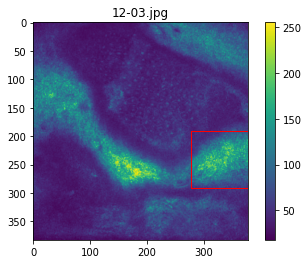

74-2-18.jpg
ifile =  Mild 74-2 74-2-18.jpg
	shape =  (390, 376)
max sharpness is  74-2-18.jpg 6.934559820190801 138 91


<Figure size 432x288 with 0 Axes>

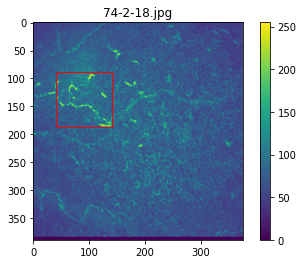

74-2-17.jpg
ifile =  Mild 74-2 74-2-17.jpg
	shape =  (387, 373)
max sharpness is  74-2-17.jpg 6.894080048282538 206 175


<Figure size 432x288 with 0 Axes>

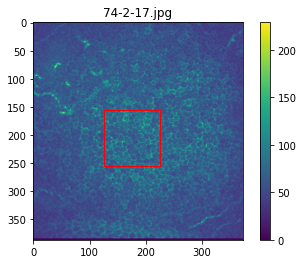

74-1-28.jpg
ifile =  Mild 74-1 74-1-28.jpg
	shape =  (382, 381)
max sharpness is  74-1-28.jpg 3.2040474581282536 162 156


<Figure size 432x288 with 0 Axes>

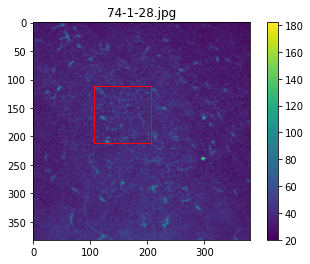

65-1-36.jpg
ifile =  Mild 65-1 65-1-36.jpg
	shape =  (387, 379)
max sharpness is  65-1-36.jpg 8.502583582023616 208 281


<Figure size 432x288 with 0 Axes>

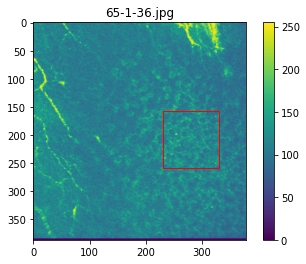

65-1-37.jpg
ifile =  Mild 65-1 65-1-37.jpg
	shape =  (383, 378)
max sharpness is  65-1-37.jpg 7.72487753434702 255 50


<Figure size 432x288 with 0 Axes>

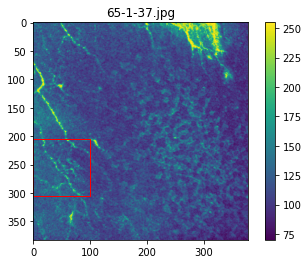

12-0-34.jpg
ifile =  Mild 12-0 12-0-34.jpg
	shape =  (395, 369)
max sharpness is  12-0-34.jpg 5.390276156436697 223 130


<Figure size 432x288 with 0 Axes>

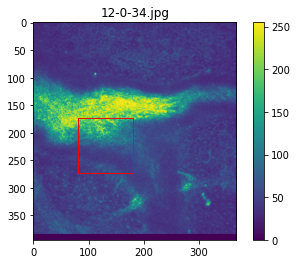

12-1-24.jpg
ifile =  Mild 12-1 12-1-24.jpg
	shape =  (389, 378)
max sharpness is  12-1-24.jpg 3.2644684893448863 222 197


<Figure size 432x288 with 0 Axes>

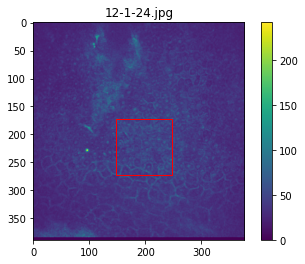

50-53-33.jpg
ifile =  Mild 50-53 50-53-33.jpg
	shape =  (380, 373)
max sharpness is  50-53-33.jpg 4.8588621600130315 159 153


<Figure size 432x288 with 0 Axes>

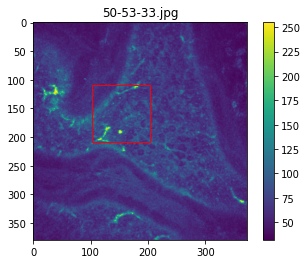

50-53-32.jpg
ifile =  Mild 50-53 50-53-32.jpg
	shape =  (382, 377)
max sharpness is  50-53-32.jpg 4.457461747893151 178 93


<Figure size 432x288 with 0 Axes>

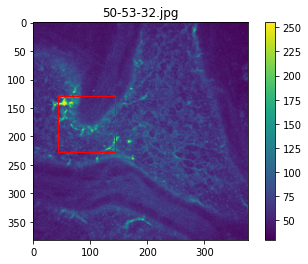

65-2-15.jpg
ifile =  Mild 65-2 65-2-15.jpg
	shape =  (388, 378)
max sharpness is  65-2-15.jpg 7.486643123932129 50 67


<Figure size 432x288 with 0 Axes>

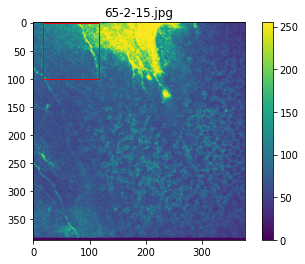

50-54-25.jpg
ifile =  Mild 50-54 50-54-25.jpg
	shape =  (387, 378)
max sharpness is  50-54-25.jpg 6.468005622276757 221 129


<Figure size 432x288 with 0 Axes>

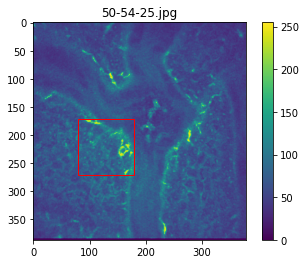

14-6-18.jpg
ifile =  Severe 14-6 14-6-18.jpg
	shape =  (389, 378)
max sharpness is  14-6-18.jpg 1.3648753513317469 182 167


<Figure size 432x288 with 0 Axes>

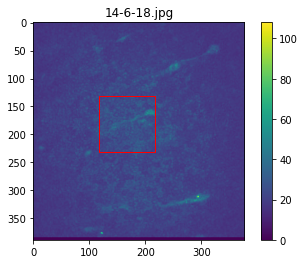

14-6-23.jpg
ifile =  Severe 14-6 14-6-23.jpg
	shape =  (390, 377)
max sharpness is  14-6-23.jpg 1.8965037889870588 171 183


<Figure size 432x288 with 0 Axes>

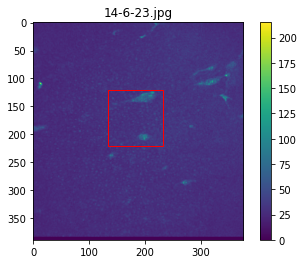

87-38-35.jpg
ifile =  Severe 87-38 87-38-35.jpg
	shape =  (384, 384)
max sharpness is  87-38-35.jpg 7.092946176989775 280 131


<Figure size 432x288 with 0 Axes>

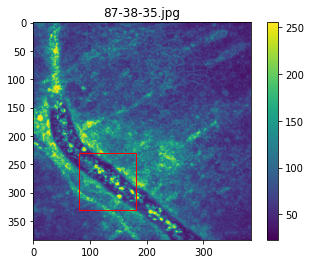

39-12-28.jpg
ifile =  Severe 39-12 39-12-28.jpg
	shape =  (385, 376)
max sharpness is  39-12-28.jpg 2.148332537400112 143 253


<Figure size 432x288 with 0 Axes>

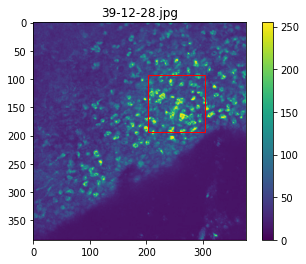

14-5-20.jpg
ifile =  Severe 14-5 14-5-20.jpg
	shape =  (388, 379)
max sharpness is  14-5-20.jpg 3.503752403456996 186 103


<Figure size 432x288 with 0 Axes>

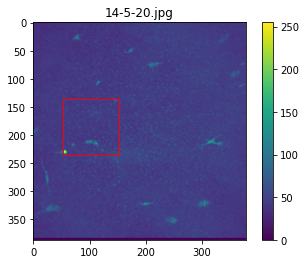

87-2-22.jpg
ifile =  Severe 87-2 87-2-22.jpg
	shape =  (383, 378)
max sharpness is  87-2-22.jpg 6.8261739408013735 248 155


<Figure size 432x288 with 0 Axes>

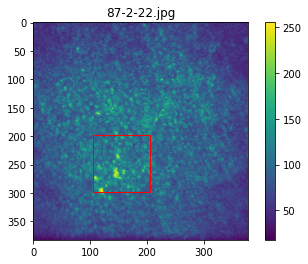

39-13-22.jpg
ifile =  Severe 39-13 39-13-22.jpg
	shape =  (384, 384)
max sharpness is  39-13-22.jpg 5.05605213235298 111 281


<Figure size 432x288 with 0 Axes>

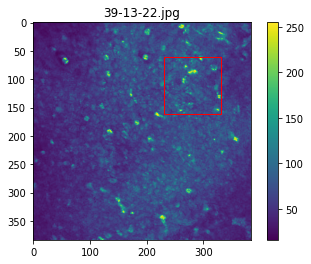

39-13-24.jpg
ifile =  Severe 39-13 39-13-24.jpg
	shape =  (384, 384)
max sharpness is  39-13-24.jpg 6.641033530044698 276 254


<Figure size 432x288 with 0 Axes>

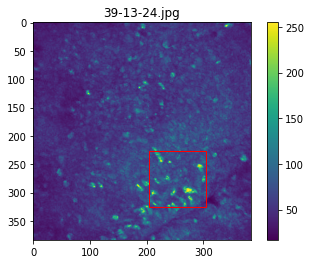

87-3-64.jpg
ifile =  Severe 87-3 87-3-64.jpg
	shape =  (389, 378)
max sharpness is  87-3-64.jpg 6.137772901081325 207 278


<Figure size 432x288 with 0 Axes>

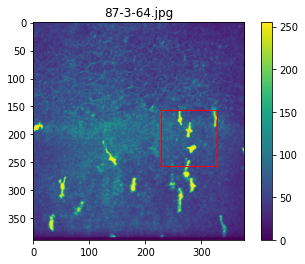

87-37.jpg
ifile =  Severe 87-37 87-37.jpg
	shape =  (387, 379)
max sharpness is  87-37.jpg 8.31674157038646 61 209


<Figure size 432x288 with 0 Axes>

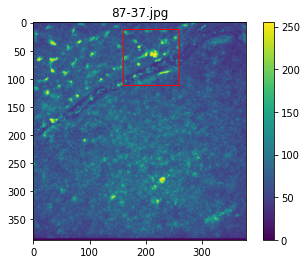

50-9-18.jpg
ifile =  Moderate 50-9 50-9-18.jpg
	shape =  (377, 376)
max sharpness is  50-9-18.jpg 7.167632178152392 198 227


<Figure size 432x288 with 0 Axes>

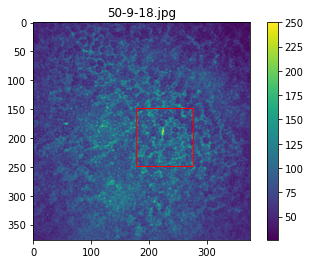

50--9-21.jpg
ifile =  Moderate 50-9 50--9-21.jpg
	shape =  (384, 379)
max sharpness is  50--9-21.jpg 10.27000354281581 196 222


<Figure size 432x288 with 0 Axes>

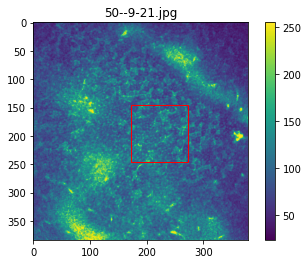

50-9-19.jpg
ifile =  Moderate 50-9 50-9-19.jpg
	shape =  (383, 378)
max sharpness is  50-9-19.jpg 8.173976866375053 183 220


<Figure size 432x288 with 0 Axes>

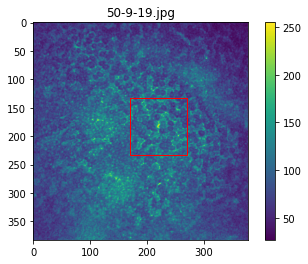

76-7-26.jpg
ifile =  Moderate 76-7 76-7-26.jpg
	shape =  (385, 376)
max sharpness is  76-7-26.jpg 5.550591943505178 286 175


<Figure size 432x288 with 0 Axes>

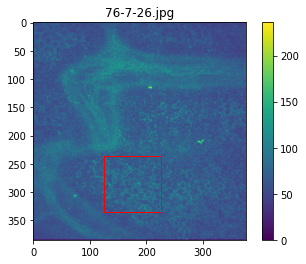

76-7-32.jpg
ifile =  Moderate 76-7 76-7-32.jpg
	shape =  (390, 376)
max sharpness is  76-7-32.jpg 7.117179620772587 106 321


<Figure size 432x288 with 0 Axes>

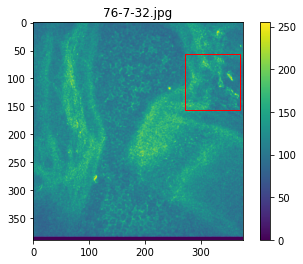

4-1-23.jpg
ifile =  Moderate 4-1 4-1-23.jpg
	shape =  (383, 377)
max sharpness is  4-1-23.jpg 5.861246508754611 191 260


<Figure size 432x288 with 0 Axes>

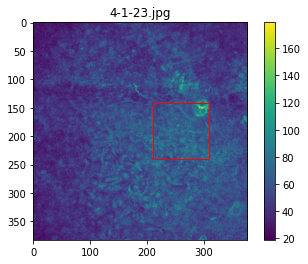

4-1-24.jpg
ifile =  Moderate 4-1 4-1-24.jpg
	shape =  (388, 379)
max sharpness is  4-1-24.jpg 6.663263667458284 207 270


<Figure size 432x288 with 0 Axes>

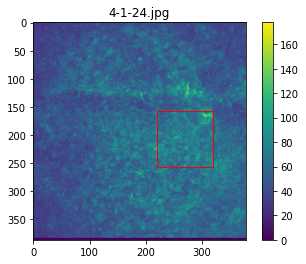

4-1-22.jpg
ifile =  Moderate 4-1 4-1-22.jpg
	shape =  (387, 379)
max sharpness is  4-1-22.jpg 4.721286596574038 218 242


<Figure size 432x288 with 0 Axes>

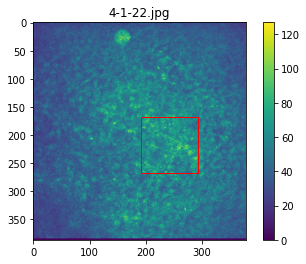

4-18-19.jpg
ifile =  Moderate 4-18 4-18-19.jpg
	shape =  (383, 376)
max sharpness is  4-18-19.jpg 4.887756872275986 214 245


<Figure size 432x288 with 0 Axes>

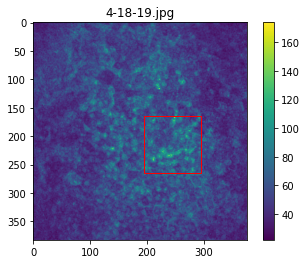

4-18-21.jpg
ifile =  Moderate 4-18 4-18-21.jpg
	shape =  (387, 378)
max sharpness is  4-18-21.jpg 7.103762170148727 57 222


<Figure size 432x288 with 0 Axes>

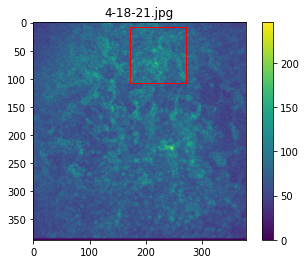

4-18-22.jpg
ifile =  Moderate 4-18 4-18-22.jpg
	shape =  (391, 377)
max sharpness is  4-18-22.jpg 8.292206501305115 72 175


<Figure size 432x288 with 0 Axes>

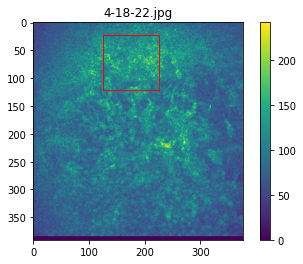

76-8-27.jpg
ifile =  Moderate 76-8 76-8-27.jpg
	shape =  (383, 379)
max sharpness is  76-8-27.jpg 7.318921774108354 109 269


<Figure size 432x288 with 0 Axes>

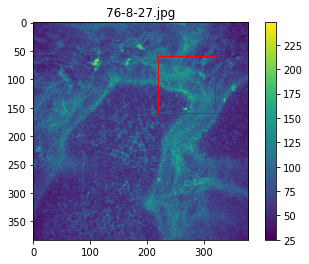

N2-na-od-6-21.jpg
ifile =  Control N2-6 N2-na-od-6-21.jpg
	shape =  (385, 379)
max sharpness is  N2-na-od-6-21.jpg 3.115318067779781 236 219


<Figure size 432x288 with 0 Axes>

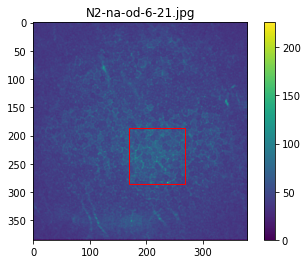

N2-na-od-0-25.jpg
ifile =  Control N2-0 N2-na-od-0-25.jpg
	shape =  (393, 372)
max sharpness is  N2-na-od-0-25.jpg 1.8239838554886694 199 231


<Figure size 432x288 with 0 Axes>

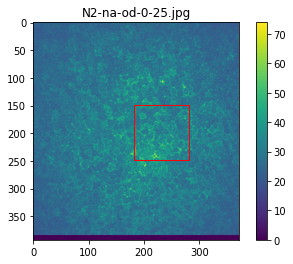

N2-na-od-0-26.jpg
ifile =  Control N2-0 N2-na-od-0-26.jpg
	shape =  (389, 379)
max sharpness is  N2-na-od-0-26.jpg 2.134265301152735 179 219


<Figure size 432x288 with 0 Axes>

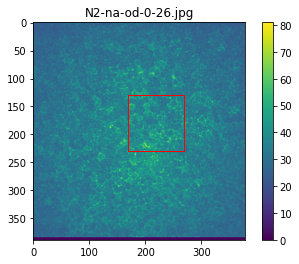

N1-1.jpg
ifile =  Control N1-1 N1-1.jpg
	shape =  (578, 576)
max sharpness is  N1-1.jpg 2.4018681522675265 257 51


<Figure size 432x288 with 0 Axes>

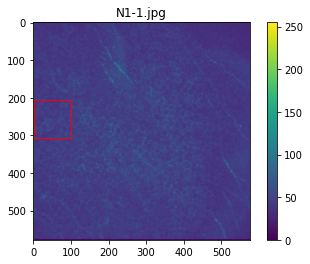

N3-2-32.jpg
ifile =  Control N3-2 N3-2-32.jpg
	shape =  (386, 379)
max sharpness is  N3-2-32.jpg 5.531326360798644 201 81


<Figure size 432x288 with 0 Axes>

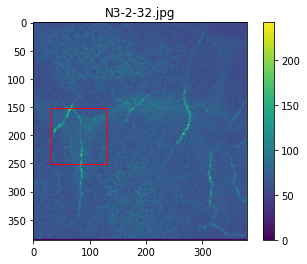

N3-1-30.jpg
ifile =  Control N3-1 N3-1-30.jpg
	shape =  (386, 379)
max sharpness is  N3-1-30.jpg 6.288069194838239 262 270


<Figure size 432x288 with 0 Axes>

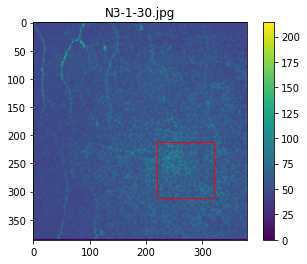

N3-1-31.jpg
ifile =  Control N3-1 N3-1-31.jpg
	shape =  (385, 379)
max sharpness is  N3-1-31.jpg 5.15591467829288 239 304


<Figure size 432x288 with 0 Axes>

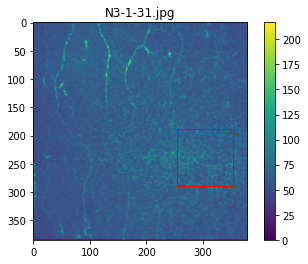

N1-2-30.jpg
ifile =  Control N1-2 N1-2-30.jpg
	shape =  (580, 572)
max sharpness is  N1-2-30.jpg 1.751746733766191 373 378


<Figure size 432x288 with 0 Axes>

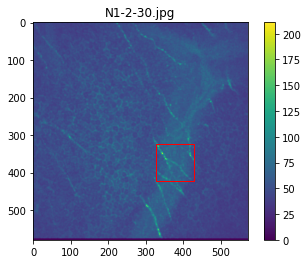

N1-2-31.jpg
ifile =  Control N1-2 N1-2-31.jpg
	shape =  (578, 574)
max sharpness is  N1-2-31.jpg 2.2633439444233656 367 339


<Figure size 432x288 with 0 Axes>

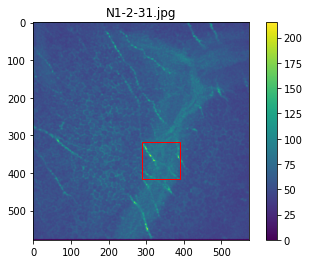

N1-47-23.jpg
ifile =  Control N1-47 N1-47-23.jpg
	shape =  (384, 384)
max sharpness is  N1-47-23.jpg 4.569705370228671 278 194


<Figure size 432x288 with 0 Axes>

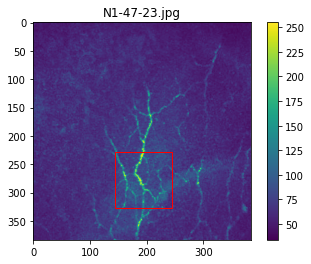

N1-46-16.jpg
ifile =  Control N1-46 N1-46-16.jpg
	shape =  (384, 379)
max sharpness is  N1-46-16.jpg 6.910497340205384 181 111


<Figure size 432x288 with 0 Axes>

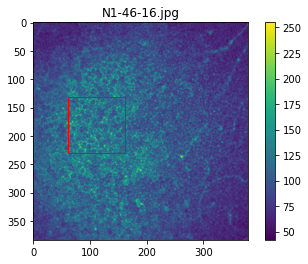

N1-46-17.jpg
ifile =  Control N1-46 N1-46-17.jpg
	shape =  (387, 379)
max sharpness is  N1-46-17.jpg 7.817231116306234 232 123


<Figure size 432x288 with 0 Axes>

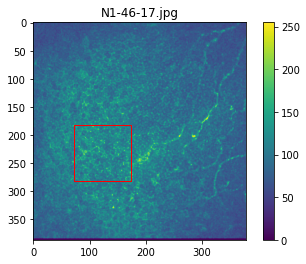

<Figure size 432x288 with 0 Axes>

In [0]:
'''
Get patches
'''

for ikey in im.keys():
    for ptype in im[ikey].keys():
        for ptfolder in im[ikey][ptype].keys():
            for ifile in im[ikey][ptype][ptfolder].keys():
                print(ifile)
                imdata = im[ikey][ptype][ptfolder][ifile]
                print('ifile = ',ikey,ptfolder,ifile)
                if (np.size(imdata)> 0):
                    image_shape = np.shape(imdata)
                    print('\tshape = ',image_shape)
                    irow = image_shape[0]
                    icol = image_shape[1]


                    box_length = 50
                    max_sharpness = 0.0
                    max_row = 0
                    max_col = 0
                    for row in range(box_length, irow- box_length):
                        for col in range(box_length, icol - box_length):
                            square_data =get_square(imdata,row,col,box_length)
                            
                            #
                            # check to see if vessel hijacking values
                            #

                            #get max intensity and lowest intensity
                            max_i = np.max(imdata)
                            min_i = np.min(imdata)


                            high_intensity = np.argwhere(square_data >= (max_i * 0.75))
                            numels = np.size(square_data)
                            
                            if (np.size(high_intensity) > (numels*0.15)):
                                #lots of high intensity pixels found in this
                                #print('max, min,numels is ',max_i,min_i,numels,np.size(high_intensity))
                                #print('too many High I pixels. Drop this one')
                                continue

                            gy,gx = np.gradient(square_data)

                            gnorm = np.sqrt(gx**2 + gy**2)
                            sharpness_number = np.average(gnorm)

                            if (sharpness_number > max_sharpness):
                                max_sharpness = sharpness_number
                                max_row = row
                                max_col = col
                    print('max sharpness is ',ifile, sharpness_number,max_row,max_col)
                else:
                    print('found an empty file', ptfolder, ifile)
                
                #
                # Show box with greatest sharpness
                #
                left_wall = max_col - box_length
                right_wall = max_col + box_length
                low_wall = max_row - box_length
                high_wall = max_row + box_length

                plt.figure()
                plt.imshow(imdata)
                plt.title(ifile)
                plt.colorbar()

                rect = patches.Rectangle((left_wall,low_wall),box_length*2,box_length*2,linewidth=1,edgecolor='r',facecolor='none')

                # Get the current reference
                ax = plt.gca()
                # Add the patch to the Axes
                ax.add_patch(rect)
                plt.show()

                
                #
                #histogram
                #
                hist, bin_edges= np.histogram(imdata)
                plt.figure()
                


#get_square(im, row, col,dlength)



(395, 369, 3)


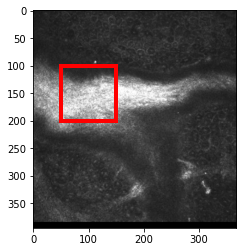

single pixel =  [248 248 248]


(array([16., 46., 13.,  4.,  4.,  4.,  2.,  0.,  1.,  1.,  2.,  3.,  5.,
         4.,  7., 10.,  6., 13., 20., 13., 17., 22., 15., 14., 10., 17.,
        20., 24., 32., 24.]),
 array([ 31.        ,  38.46666667,  45.93333333,  53.4       ,
         60.86666667,  68.33333333,  75.8       ,  83.26666667,
         90.73333333,  98.2       , 105.66666667, 113.13333333,
        120.6       , 128.06666667, 135.53333333, 143.        ,
        150.46666667, 157.93333333, 165.4       , 172.86666667,
        180.33333333, 187.8       , 195.26666667, 202.73333333,
        210.2       , 217.66666667, 225.13333333, 232.6       ,
        240.06666667, 247.53333333, 255.        ]),
 <a list of 30 Patch objects>)

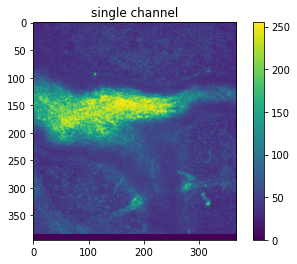

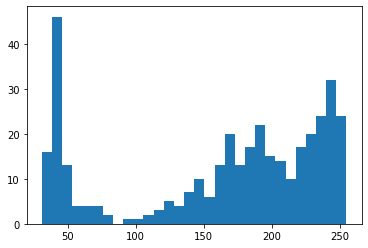

In [0]:
a = im['Severe']['Anonymized']['87-38']['87-38-35.jpg']
#f = '/content/gdrive/My Drive/BE224B_2020/Central BCD4/Severe/Anonymized/87-38/87-38-35.jpg'



f='/content/gdrive/My Drive/BE224B_2020/Central BCD4/Mild/Anonymized/12-0/12-0-34.jpg'



rgb =  imageio.imread(f)
gray_image = rgb #np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

print(np.shape(rgb))


plt.figure()
plt.imshow(gray_image)
rect = patches.Rectangle((50,100),100,100,linewidth=4,edgecolor='r',facecolor='none')

# Get the current reference
ax = plt.gca()


# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

plt.figure()
plt.imshow(rgb[:,:,2])
plt.colorbar()
plt.title('single channel')

print('single pixel = ', rgb[150,180,:])


plt.figure()
plt.hist(rgb[150,:,0],bins= 30)

sharpness is  4.743985219165623


"\n#im = Image.open(filename).convert('L') # to grayscale\narray = np.asarray(im, dtype=np.int32)\n\ngy, gx = np.gradient(array)\ngnorm = np.sqrt(gx**2 + gy**2)\nsharpness = np.average(gnorm)\n"

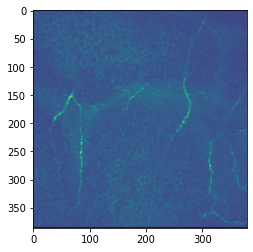

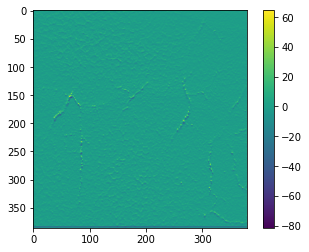

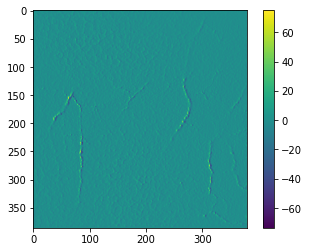

In [0]:
a = im['Control']['Anonymized']['N3-2']['N3-2-32.jpg']
plt.figure()
plt.imshow(a)

'''
red = a[:,:,0]
green = a[:,:,1]
blue = a[:,:,2]



gray = 0.2989 * red + 0.5870 * green + 0.1140 * blue
g2=np.dot(a[...,:3], [0.299, 0.587, 0.114])
'''


gy,gx = np.gradient(a)

gnorm = np.sqrt(gx**2 + gy**2)
sharpness_number = np.average(gnorm)

print('sharpness is ',sharpness_number)

plt.figure()
plt.imshow(gy)
plt.colorbar()


plt.figure()
plt.imshow(gx)
plt.colorbar()

'''
#im = Image.open(filename).convert('L') # to grayscale
array = np.asarray(im, dtype=np.int32)

gy, gx = np.gradient(array)
gnorm = np.sqrt(gx**2 + gy**2)
sharpness = np.average(gnorm)
'''
